# UNIVERSIDAD POLITECNICA SALESIANA  

# - SISTEMA DE RECOMENDACION  

## INTEGRANTES: JAVIER YUNGA, JONNATHAN MATUTE 

###  IMPOTAMOS LAS LIBRERIAS  

In [25]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

print('Librerias importadas')

Librerias importadas


### CARGAMOS EL DATASET MOVIELENS 

In [142]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

### VISUALIZAMOS LOS DATOS DE USUARIOS

In [143]:
# Data de usuarios
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols,encoding='latin-1')

In [144]:
# Ahora podemos revisar la data
print(users.shape)
users.head()

(943, 5)


,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


### VISUALIZAMOS LOS DATOS DE RATINGS 

In [145]:
# Data de ratings
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols,encoding='latin-1')

In [146]:
print(ratings.shape)
ratings.head()

(100000, 4)


,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### VISUALIZAMOS LOS DATOS DE LAS PELICULAS  

In [147]:
# Data de películas
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv('ml-100k/u.item', sep='|', names=i_cols,
encoding='latin-1')

In [148]:
print(items.shape)
items.head()

(1682, 24)


,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [149]:
seed = 7
np.random.seed(seed)

x_tr = ratings.drop(['rating'], axis=1)
y_tr = ratings.drop(['user_id','movie_id','unix_timestamp'],axis=1)

### NORMALIZAMOS  

In [150]:
y_tr=np.reshape(y_tr, (-1,1))
y_tr
#Normalización
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
print(scaler_x.fit(x_tr))
xscale=scaler_x.transform(x_tr)
print(scaler_y.fit(y_tr))
yscale=scaler_y.transform(y_tr)

MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))


###  DIVISION EN TRAIN Y TEST

In [116]:
#Split en train y test.
X_train, X_test, y_train, y_test = train_test_split(xscale, yscale)

###  REALIZAMOS UN PREPROCESAMIENTO PARA CODIFICAR  USUARIOS Y PELICULAS COMO INDICES ENTEROS. 

In [117]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


### SE PREPARA LOS DATOS DE CAPACITACION Y VALIDACION 

In [118]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

### CREAMOS EL MODELO CON 50 DIMENSIONES 

In [119]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

### EVALUAMOS LAS FUNCION DE COSTO O PERDIDA (MSE,MAE) 

In [120]:
# Las funciones de costo o pérdida son: mean_squared_error (mse) y mean_absolute_error (mae)
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])



### ENTRENAMOS EL MODELO CON LA DIVISION DE DATOS. 

In [140]:
from time import time 
tiempo_inicial = time()
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5, #Numero de epochs
    verbose=1,
    validation_data=(x_val, y_val),
    
    
)

Train on 90752 samples, validate on 10084 samples
Epoch 1/5
90752/90752 [==============================] - 7s 81us/sample - loss: 0.0409 - mse: 0.0396 - mae: 0.1545 - val_loss: 0.0423 - val_mse: 0.0410 - val_mae: 0.1580
Epoch 2/5
90752/90752 [==============================] - 7s 74us/sample - loss: 0.0406 - mse: 0.0392 - mae: 0.1531 - val_loss: 0.0429 - val_mse: 0.0414 - val_mae: 0.1583
Epoch 3/5
90752/90752 [==============================] - 7s 74us/sample - loss: 0.0401 - mse: 0.0386 - mae: 0.1518 - val_loss: 0.0434 - val_mse: 0.0419 - val_mae: 0.1596
Epoch 4/5
90752/90752 [==============================] - 7s 76us/sample - loss: 0.0400 - mse: 0.0384 - mae: 0.1514 - val_loss: 0.0432 - val_mse: 0.0416 - val_mae: 0.1586
Epoch 5/5
90752/90752 [==============================] - 7s 78us/sample - loss: 0.0402 - mse: 0.0385 - mae: 0.1516 - val_loss: 0.0438 - val_mse: 0.0420 - val_mae: 0.1588


In [122]:
scores = model.evaluate(x_train, y_train)
scores

90752/90752 [==============================] - 8s 90us/sample - loss: 0.0429 - mse: 0.0417 - mae: 0.1630


[0.04287997452307057, 0.04169196, 0.16297834]

In [123]:
t=ratings.iloc[5,:]
p=x_tr.iloc[2,:]
t

user_id                 298
movie_id                474
rating                    4
unix_timestamp    884182806
Name: 5, dtype: int64

### GRAFICAMOS EL MODELO ENTRENADO Y PERDIDA DE VALIDACION 

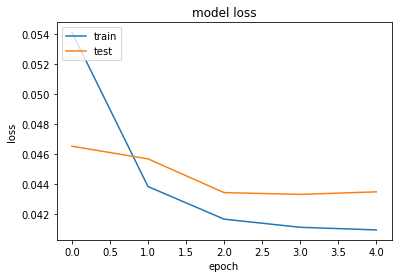

In [124]:
# Graficamos el modelo entrenado con base a los epoch , por medio de train y test
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
#%% Carga de librerías.
import pandas as pd
from sklearn import preprocessing 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [126]:
# Data de ratings
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols,encoding='latin-1')

In [127]:
data = ratings.iloc[:, 0:2]

In [128]:
min_max_scaler = preprocessing.MinMaxScaler() 
df_escalado = min_max_scaler.fit_transform(data)
df_escalado = pd.DataFrame(df_escalado) # Hay que convertir a DF el resultado.
df_escalado = df_escalado.rename(columns = {0: 'user_id', 1: 'movie_id'})

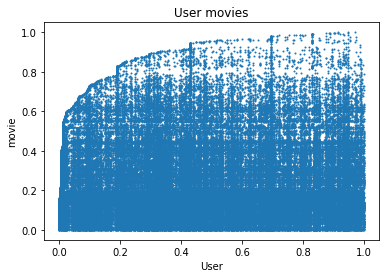

In [129]:
x = df_escalado['user_id'].values
y = df_escalado['movie_id'].values
plt.xlabel('User')
plt.ylabel('movie')
plt.title('User movies')
plt.plot(x,y,'o',markersize=1)

### DETERMINAR LA CURVA OPTIMA  POR MEDIO DE CLUSTERES (K)

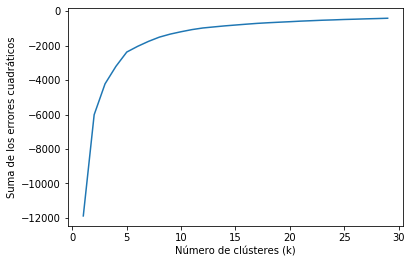

In [99]:
#%% Curva elbow para determinar valor óptimo de k.
nc = range(1, 30) # El número de iteraciones que queremos hacer.
kmeans = [KMeans(n_clusters=i) for i in nc]
score = [kmeans[i].fit(df_escalado).score(df_escalado) for i in range(len(kmeans))]
score
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de los errores cuadráticos')
plt.plot(nc,score)

### APLICAMOS K-MEANS CON K = 5 

In [130]:
#%% Aplicación de k-means con k = 5.
kmeans = KMeans(n_clusters=5).fit(df_escalado)
centroids = kmeans.cluster_centers_
print(centroids)

[[0.1425634  0.15773491]
 [0.82475241 0.1465323 ]
 [0.295277   0.52834426]
 [0.45785958 0.15457985]
 [0.76731263 0.51537843]]


### GENERAMOS EL MEJOR TIEMPO CON EL USER_ID (200) 

In [131]:
is_male = ratings.loc[:, 'user_id'] == 200
df_male = ratings.loc[is_male]
df_male.head()

,user_id,movie_id,rating,unix_timestamp
12,200,222,5,876042340
189,200,673,5,884128554
243,200,318,5,884128458
326,200,304,5,876041644
367,200,96,5,884129409


### RECOMENDACION DE PELICULAS TENIENDO EN CUENTA EL TIEMPO  

In [138]:
count=0
recomendados=[]
time=[]
for index, row in df_male.iterrows():
    if(row['rating']>4 and count<5):
        count=count+1
        movie=row['movie_id']
        tiempo=row['unix_timestamp']
        recomendados.append(movie)
        time.append(tiempo)
recomendados

[222, 673, 318, 304, 96]

### MOSTRAMOS LAS 10 MEJORES RECOMENDACIONES DE PELICULAS A UN USUARIO. 

In [137]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Mostrando recomendaciones para el usuario: {}".format(user_id))
print("====" * 9)
print("Películas con altas calificaciones del usuario")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Las 10 mejores recomendaciones de películas")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

    

Mostrando recomendaciones para el usuario: 414
Películas con altas calificaciones del usuario
--------------------------------
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War
Some Like It Hot (1959) : Comedy|Crime
Wallace & Gromit: The Wrong Trousers (1993) : Animation|Children|Comedy|Crime
L.A. Confidential (1997) : Crime|Film-Noir|Mystery|Thriller
Rushmore (1998) : Comedy|Drama
--------------------------------
Las 10 mejores recomendaciones de películas
--------------------------------
Hoop Dreams (1994) : Documentary
Philadelphia Story, The (1940) : Comedy|Drama|Romance
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950) : Drama|Film-Noir|Romance
Secrets & Lies (1996) : Drama
12 Angry Men (1957) : Drama
Third Man, The (1949) : Film-Noir|Mystery|Thriller
Psycho (1960) : Crime|Horror
Miller's Crossing (1990) : Crime|Drama|Film-Noir|Thriller
Touch of Evil (1958) : Crime|Film-Noir|Thriller
Shining, The (1980) : Horror
